In [1]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, AddMultibodyPlantSceneGraph, SolverOptions, 
                         CommonSolverOption)

from pydrake.solvers.mosek import MosekSolver
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

In [2]:
x = Variable("x")
theta = Variable("t")
xdot = Variable("\dot{x}")
thetadot = Variable("\dot{t}")
u_symbolic = Variable("u")
garbage = Variable("garbage")

x = np.hstack([x, theta, xdot, thetadot])

In [3]:
mp = 5
mc = 10
l = 2.5
gravity = 9.8

In [4]:
M = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, l*mp*pf.cos(theta)], 
             [0, 0, l*mp*pf.cos(theta), l**2*mp]])

E = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, -l*mp], 
             [0, 0, -l*mp, l**2*mp]])

A = np.array([[0, 0, 1, 0], 
             [0, 0, 0, 1], 
             [0, 0, 0, 0], 
             [0, gravity*l*mp, 0, 0]])

B = np.array([[0], [0], [1], [0]])

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [5]:
A_cloop = A - B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E=E.T)

np.linalg.eigvals(P)

array([5.32767157e+02, 1.43095907e+00, 2.43853431e-03, 2.27325103e-04])

In [6]:
K

array([[ -3.16227766, 387.03174947, -12.48629485, 168.92395316]])

In [7]:
K_casted = np.insert(K, 2, 0)
K_casted

array([ -3.16227766, 387.03174947,   0.        , -12.48629485,
       168.92395316])

In [8]:
X

array([[ 3.94851313e+01, -5.34184443e+02, -3.16227766e+00,
        -9.99103555e+00],
       [-5.34184443e+02,  3.13306629e+04,  3.87031749e+02,
         6.11361531e+02],
       [-3.16227766e+00,  3.87031749e+02,  5.50832864e+00,
         7.60889796e+00],
       [-9.99103555e+00,  6.11361531e+02,  7.60889796e+00,
         1.19378012e+01]])

In [9]:
K2 = B.T@X@M

In [10]:
K2

array([[-3.162277660131121, 387.03174946597244,
        <Expression "(82.624929625693966 + 95.111224472106187 * cos(t))">,
        <Expression "(237.7780611802655 + 68.854108021411648 * cos(t))">]],
      dtype=object)

In [11]:
K2

array([[-3.162277660131121, 387.03174946597244,
        <Expression "(82.624929625693966 + 95.111224472106187 * cos(t))">,
        <Expression "(237.7780611802655 + 68.854108021411648 * cos(t))">]],
      dtype=object)

In [ ]:
# testing both the controllers
def UprightState():
    return np.array([0, np.pi, 0, 0])

print('HI')
# defining the controller

u = -K@(x  - UprightState())
own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

u2 = -K2@(x - UprightState())
own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u2)

#defining the system
exp_dynamics = np.array([xdot, 
                         thetadot, 
                         (1/(mc+mp*(pf.sin(theta))**2))*(u_symbolic + \
                                            mp*pf.sin(theta)*(l*thetadot**2+gravity*pf.cos(theta))),
                         (1/(l*mc+l*mp*(pf.sin(theta))**2))*(-u_symbolic*pf.cos(theta) \
                                -mp*l*thetadot**2*pf.cos(theta)*pf.sin(theta)-(mc+mp)*gravity*pf.sin(theta))])
system = SymbolicVectorSystem(state=x, input=[u_symbolic], dynamics=exp_dynamics, output=x)



builder = DiagramBuilder()
# plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
# file_name = FindResource("models/cartpole.urdf")
# Parser(plant).AddModelFromFile(file_name)
# plant.Finalize()
# print('Plant Finalised')

plant = builder.AddSystem(system)
wrapangles = WrapToSystem(4)
wrapangles.set_interval(1, 0, 2. * np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(plant.get_output_port(0), wrapto.get_input_port(0))
controller = builder.AddSystem(own_controller)
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0),
                plant.get_input_port())

logger = LogVectorOutput(plant.get_output_port(), builder)

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
#plant_context = plant.GetMyMutableContextFromRoot(context)

# Simulate
simulator.set_target_realtime_rate(0)
duration = 80

for i in range(1):
    context.SetTime(0.)
#     plant.SetPositionsAndVelocities(
#         plant_context,
#         UprightState() + 0.9 * np.random.randn(4,))
    trial = np.append(UprightState(), 0) - 0.1*np.random.randn(5)
    trial = np.array([1.21, 5, 0, 0, 0])
    print(trial)
    context.SetContinuousState(trial)
    simulator.Initialize()
    simulator.AdvanceTo(duration)
    
    log = logger.FindLog(context)
    
    end_state = log.data()[:, -1]
    print(end_state)
    diff = np.abs(end_state - UprightState())
    print(diff)
    print(diff < np.ones(4)*5e-2)
    print(log.data()[1][-1])
    plt.figure(figsize=(5, 4))
    plt.plot(log.sample_times(), log.data().transpose()[:, :2])
    plt.xlabel('t')
    plt.ylabel('y(t)')

In [44]:
# def find_implicit_V(B, X, S, V): 
prog = MathematicalProgram()
x_p = prog.NewIndeterminates(1, "x")
t = prog.NewIndeterminates(1, "t")
x_pd = prog.NewIndeterminates(1, "\dot{x}")
td = prog.NewIndeterminates(1, "\dot{t}")
s = prog.NewIndeterminates(1, "s")
c = prog.NewIndeterminates(1, "c")

rho = prog.NewContinuousVariables(1, 'rho')[0]
alpha = prog.NewContinuousVariables(1, 'alpha')[0]

x = np.hstack([x_p, s, c, x_pd, td])
x_0 = np.array([0, 0, -1, 0, 0])
z = np.hstack([x_p, t, x_pd, td])

M44 = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, l*mp*c[0]], 
             [0, 0, l*mp*c[0], l**2*mp]])

Mdot44 = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, 0, -l*mp*s[0]*td[0]], 
             [0, 0, -l*mp*s[0]*td[0], 0]])

Vz = Polynomial(z.T@M44.T@P@M44@z)

V = 0
for m, coeff in Vz.monomial_to_coefficient_map().items(): 
    #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
    monomial = coeff
    for i in range(1, 3): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            monomial*=x[0]**d
        if i==1:
            if d == 1:
                monomial *= -x[1]
            elif d == 2:
                monomial *= (2+2*x[2])
        elif i==2 or i==3:
            monomial *= x[i+1]**d
    #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
    V += monomial

V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)

K2 = B.T@X@M44
u = -K2@z

fz = np.array([x_pd[0], 
              td[0], 
              mp*l*td[0]**2*s[0] + u[0],
              -mp*gravity*l*s[0]])

Vdotz = fz.T@P@M44@z + z.T@Mdot44.T@P@M44@z + z.T@M44.T@P@Mdot44@z + z.T@M44.T@P@fz
Vdotz = Polynomial(Vdotz)

Vdot = 0
for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
    #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
    monomial = coeff
    for i in range(1, 3): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            monomial*=x[0]**d
        if i==1:
            if d == 1:
                monomial *= -x[1]
            elif d == 2:
                monomial *= (2+2*x[2])
        elif i==2 or i==3:
            monomial *= x[i+1]**d
    #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
    Vdot += monomial
Vdot = Polynomial(Vdot).RemoveTermsWithSmallCoefficients(1e-5)

s_deg = max(V.TotalDegree()-2, 0)
lambda_trig = prog.NewFreePolynomial(Variables(x), s_deg)
lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 4)
#lambda_ = prog.NewFreePolynomial(Variables(x), 6)

trig = Polynomial(x[1]**2 + x[2]**2)

eps = 1e-5
rho = 172.1

prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) +\
                      lambda_trig*trig+ \
                      lambda_*(V - rho))

options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')
options.SetOption(MosekSolver().solver_id(), "MSK_IPAR_NUM_THREADS", 0)


solver = MosekSolver()
result = solver.Solve(prog, solver_options=options)

assert result.is_success(), str(result.get_solver_details().solution_status)

print(rho)

172.1


In [13]:
env = {x_p[0]:0, s[0]:0, c[0]:-1, x_pd[0]:0, td[0]:0}

V.Evaluate(env)

0.0

In [14]:
prog2 = MathematicalProgram()
prog2.AddIndeterminates(x)

lambda_check_2 = prog2.NewFreePolynomial(Variables(x), 3)

trig = Polynomial(x[1]**2 + x[2]**2)
eps=1e-5
prog2.AddSosConstraint(V  - eps*Polynomial((x-x_0).dot(x-x_0)) \
                       + lambda_check_2*trig)

solver = MosekSolver()
result2 = solver.Solve(prog2)

assert result2.is_success(), str(result2.get_solver_details().solution_status)

In [15]:
a1 = Vdot.Jacobian(x)

Vdot_Hessian = []
for element in a1: 
    Vdot_Hessian.append(element.Jacobian(x))
Vdot_Hessian = np.array(Vdot_Hessian)

env = {x_p[0]:0, s[0]:0, c[0]:-1, x_pd[0]:0, td[0]:0}

Vdot_Hessian_origin = np.zeros_like(Vdot_Hessian)

for i in range(len(Vdot_Hessian)): 
    for j in range(len(Vdot_Hessian[i])): 
        Vdot_Hessian_origin[i, j] = Vdot_Hessian[i, j].Evaluate(env)
        
Vdot_Hessian_origin = np.array(Vdot_Hessian_origin, dtype=float)

np.linalg.eigvals(Vdot_Hessian_origin)

array([ 1.44585473e+04, -6.39731921e+02,  1.16050256e+01, -2.05835247e+00,
        0.00000000e+00])

In [30]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[1]**2 + x[2]**2 - 1)    
    
    eps = 1e-5
    rho = 1
    
    prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) + lambda_*(V -rho) + \
                          lambda_g.dot(g) + lambda_s*trig )
    
    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')
    options.SetOption(MosekSolver().solver_id(), "MSK_IPAR_NUM_THREADS", 0)


    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)

    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)

def verify_V_positive_definite(x, V, x_0): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    trig = Polynomial(x[1]**2 + x[2]**2 - 1)    
    
    s_deg = max(V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(x), s_deg)
    
    eps = 1e-5
    prog.AddSosConstraint(V - eps*Polynomial((x-x_0).dot(x-x_0)) + lambda_s*trig)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
    print("V assertion solution status: " + str(k))
    
    assert result.is_success()
    
    print('Reached here means result is success')

def problem_solver_implicit(K_casted, P, E):
    prog = MathematicalProgram()
    x_p = prog.NewIndeterminates(1, "x")
    t = prog.NewIndeterminates(1, "t")
    x_pd = prog.NewIndeterminates(1, "\dot{x}")
    td = prog.NewIndeterminates(1, "\dot{t}")
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    
    x = np.hstack([x_p, s, c, x_pd, td])
    x_0 = np.array([0, 0, -1, 0, 0])
    z = np.hstack([x_p, t, x_pd, td])
    
    xd = prog.NewIndeterminates(5, 'xd')

    u = -K_casted@(x - x_0)
            
    g0 = xd[0] - x_pd[0]
    g1 = xd[1] - c[0]*td[0]
    g2 = xd[2] + s[0]*td[0]
    g3 = (mc+mp)*xd[3] + mp*l*xd[4]*c[0] - mp*l*td[0]**2*s[0] - u 
    g4 = mp*l*xd[3]*c[0] + mp*l**2*xd[4] + mp*gravity*l*s[0]

    g = np.array([g0, g1, g2, g3, g4])
    
    Vz = Polynomial(z.T@E.T@P@E@z)
    V = 0
    for m, coeff in Vz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        V += monomial
            
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
        
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        verify_V_positive_definite(x, V, x_0)
#         print(rho)
        
#         Vdot = V.Jacobian(x).dot(xd)
     
#         display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
problem_solver_implicit(K_casted, P, E)

Lambda solution status: 5


AssertionError: 

### Finding the ROA Empirically

In [124]:
def UprightState():
    return np.array([0, np.pi, 0, 0])

def cart_pole_sim(use_new, num_samples, plotting):
    # defining the controller

    x = Variable("x")
    theta = Variable("t")
    xdot = Variable("\dot{x}")
    thetadot = Variable("\dot{t}")
    u_symbolic = Variable("u")
    garbage = Variable("garbage")

    x = np.hstack([x, theta, xdot, thetadot])
    u = -K@(x  - UprightState())
    own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)
    
    M = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, l*mp*pf.cos(theta)], 
             [0, 0, l*mp*pf.cos(theta), l**2*mp]])
    K2 = B.T@X@M
    u2 = -K2@(x - UprightState())
    own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u2)

    #defining the system
    exp_dynamics = np.array([xdot, 
                             thetadot, 
                             (1/(mc+mp*(pf.sin(theta))**2))*(u_symbolic + \
                                                mp*pf.sin(theta)*(l*thetadot**2+gravity*pf.cos(theta))),
                             (1/(l*mc+l*mp*(pf.sin(theta))**2))*(-u_symbolic*pf.cos(theta) \
                                -mp*l*thetadot**2*pf.cos(theta)*pf.sin(theta)-(mc+mp)*gravity*pf.sin(theta))])
    system = SymbolicVectorSystem(state=x, input=[u_symbolic], dynamics=exp_dynamics, output=x)



    builder = DiagramBuilder()
    # plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    # file_name = FindResource("models/cartpole.urdf")
    # Parser(plant).AddModelFromFile(file_name)
    # plant.Finalize()
    # print('Plant Finalised')

    plant = builder.AddSystem(system)
    controller = builder.AddSystem(own_controller_new)
    builder.Connect(plant.get_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0),
                    plant.get_input_port())

    logger = LogVectorOutput(plant.get_output_port(), builder)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    #plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(0)
    duration = 90
    

    XR = np.linspace(-50, 50, num_samples)
    TR = np.linspace(np.pi - 0.5*np.pi, np.pi+0.5*np.pi, num_samples)
    XR1, TR1 = np.meshgrid(XR, TR)

    success_list = np.zeros_like(XR1)

    for i in range(len(XR1)):
        for j in range(len(XR1[i])): 

            context.SetTime(0.)

            trial = np.array([XR1[i, j], TR1[i, j], 0, 0, 0])
            context.SetContinuousState(trial)
            simulator.Initialize()
            simulator.AdvanceTo(duration)

            log = logger.FindLog(context)
            end_state = log.data()[:, -1]
            diff = np.abs(end_state - UprightState())

            tolerance = 5e-2

            if np.sum(diff < np.ones(4)*tolerance) == 4: 
                success_list[i, j] = 1


            if plotting: 
                plt.figure(figsize=(5, 4))
                plt.plot(log.sample_times(), log.data().transpose())
                plt.xlabel('t')
                plt.ylabel('y(t)')
            print(j)
        
        print(i)
            
    return success_list, TR1, XR1

print('HERE')
init_time = time.time()
success_list, TR1, XR1 = cart_pole_sim(False, 100, False)
end_time = time.time() - init_time

HERE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43

98
99
55
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
56
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
57
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
58
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40

97
98
99
83
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
85
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
86
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39

In [127]:
np.save('cartpole100by100_new.npy', success_list)

In [125]:
success_indices = np.where(success_list == 1)

In [121]:
success_list_old = np.load('cartpole300by300.npy')
XR_old = np.linspace(-50, 50, 300)
TR_old = np.linspace(np.pi - 0.5*np.pi, np.pi+0.5*np.pi, 300)
XR1_old, TR1_old = np.meshgrid(XR_old, TR_old)
success_indices_old = np.where(success_list_old == 1)
fail_indices_old = np.where(success_list == 0)

In [87]:
V_indeterminates = list(V.indeterminates())
V_indeterminates

[Variable('x(0)', Continuous),
 Variable('\dot{x}(0)', Continuous),
 Variable('\dot{t}(0)', Continuous),
 Variable('s(0)', Continuous),
 Variable('c(0)', Continuous)]

In [92]:
V_old = Polynomial(z.T@E.T@P@E@z)
V_old_indeterminates = list(V_old.indeterminates())
V_old_indeterminates

[Variable('x(0)', Continuous),
 Variable('t(0)', Continuous),
 Variable('\dot{x}(0)', Continuous),
 Variable('\dot{t}(0)', Continuous)]

In [93]:
V_old.Evaluate({x_p[0]:0, t[0]:0, x_pd[0]:0, td[0]:0})

0.0

<IPython.core.display.Javascript object>


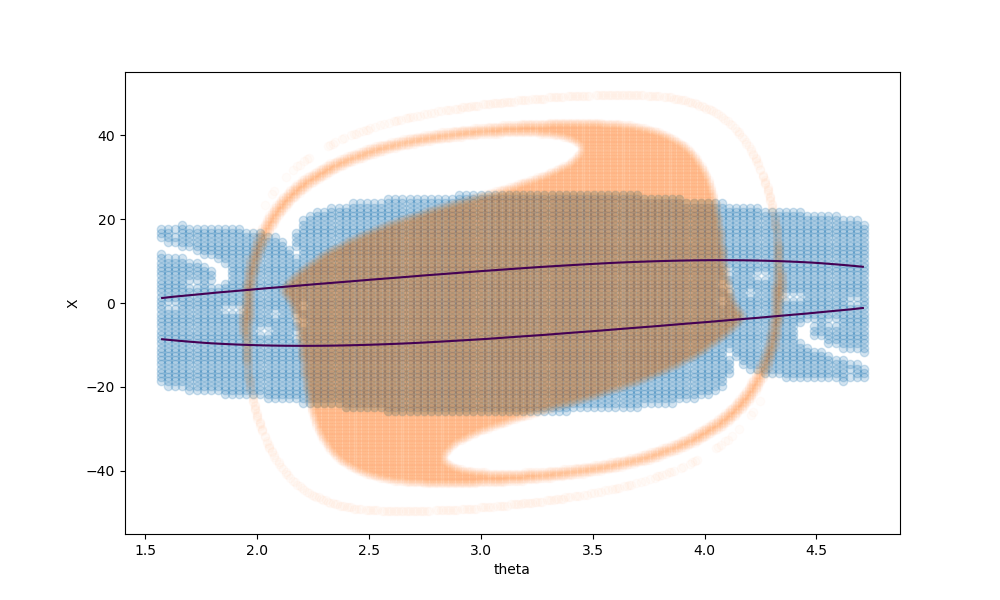

Text(0, 0.5, 'X')

In [126]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
img = ax.scatter(TR1_old[success_indices_old], XR1_old[success_indices_old], alpha=0.02)

#img = ax.scatter(TR1[fail_indices], XR1[fail_indices], alpha=0.2)

# img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)

Vplot = np.zeros_like(TR1)

env = {}
for i in range(len(TR1)):
    for j in range(len(TR1[i])): 
        env[V_indeterminates[0]] = XR1[i, j]
        env[V_indeterminates[1]] = 0
        env[V_indeterminates[2]] = 0
        env[V_indeterminates[3]] = np.sin(TR1[i, j])
        env[V_indeterminates[4]] = np.cos(TR1[i, j])
        Vplot[i, j] = V.Evaluate(env)

Vplot_old = np.zeros_like(TR1)
env_old = {}
for i in range(len(TR1)):
    for j in range(len(TR1[i])): 
        env_old[V_old_indeterminates[0]] = XR1[i, j]
        env_old[V_old_indeterminates[1]] = TR1[i, j] - np.pi
        env_old[V_old_indeterminates[2]] = 0
        env_old[V_old_indeterminates[3]] = 0
        Vplot_old[i, j] = V_old.Evaluate(env_old)
        
ax.contour(TR1,XR1, Vplot, levels=[172.5])
#ax.contour(TR1,XR1, Vplot_old, levels=[30])
# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-100, 100)
ax.set_xlabel("theta")
ax.set_ylabel("X")

In [69]:
np.linalg.eigvals(E.T@P@E)

array([3.18039005e+03, 1.78899263e+00, 1.94606501e-01, 3.91789703e-01])

In [95]:
end_time

3520.7027587890625

In [123]:
np.save('cartpole300by300.npy', success_list)

HERE
[[1.      0.00981 0.1     0.     ]
 [0.      1.21582 0.      0.1    ]
 [0.      0.0981  1.      0.     ]
 [0.      2.1582  0.      1.     ]]
[[0.001]
 [0.002]
 [0.01 ]
 [0.02 ]]
[2.         2.19911486 0.         0.        ]


<IPython.core.display.Javascript object>


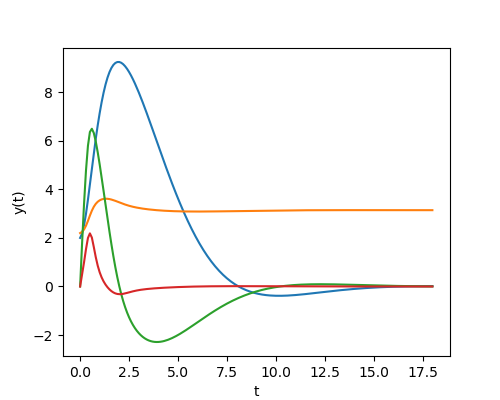

In [35]:
def cartpole_balancing_example():
    def UprightState():
        state = (0, np.pi, 0, 0)
        return state

    def Linearized_Matrices(plant):
        print('HERE')
        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])
        plant.SetPositionsAndVelocities(context, UprightState())

        linearized_plant = Linearize(
            plant,
            context,
            input_port_index=plant.get_actuation_input_port().get_index(), output_port_index=plant.get_state_output_port().get_index())
        print(linearized_plant.A())
        print(linearized_plant.B())

    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])

        plant.SetPositionsAndVelocities(context, UprightState())

        Q = np.diag((10., 10., 1., 1.))
        R = np.array([1])

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R,
            input_port_index=plant.get_actuation_input_port().get_index())

    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    file_name = FindResource("models/cartpole.urdf")
    Parser(plant).AddModelFromFile(file_name)
    plant.Finalize()
#     print('HERE')
    Linearized_Matrices(plant)

    controller = builder.AddSystem(BalancingLQR(plant))
    builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0),
                    plant.get_actuation_input_port())
    
    logger = LogVectorOutput(plant.get_state_output_port(), builder)

#     # Setup visualization
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(0)
    duration = 18
    for i in range(1):
        context.SetTime(0.)
    #     plant.SetPositionsAndVelocities(
    #         plant_context,
    #         UprightState() + 0.9 * np.random.randn(4,))
        trial = np.append(UprightState(), 0) - 0.1*np.random.randn(5)
        trial = np.array([2, np.pi - 0.3*np.pi, 0, 0])
        print(trial)
        plant.SetPositionsAndVelocities(
            plant_context, trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)

        log = logger.FindLog(context)

        end_state = log.data()[:, -1]
        diff = np.abs(end_state - UprightState())
        plt.figure(figsize=(5, 4))
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)')

#np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
cartpole_balancing_example()

In [48]:
np.linalg.inv(E)@A

array([[ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.98,  0.  ,  0.  ],
       [ 0.  , 21.56,  0.  ,  0.  ]])

In [49]:
np.linalg.inv(E)@B

array([[0. ],
       [0. ],
       [0.1],
       [0.2]])